In [2]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from netCDF4 import Dataset
import netCDF4 as nc
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [23]:
def add_cyclic_simple(data, lons):
    shape_to_append = (data.shape[0], 1)
    add_data = data[:, 0].reshape(shape_to_append)
    cyclic_data = np.hstack((data, add_data))
    cyclic_lons = np.append(lons, 360.0)
    return cyclic_data, cyclic_lons

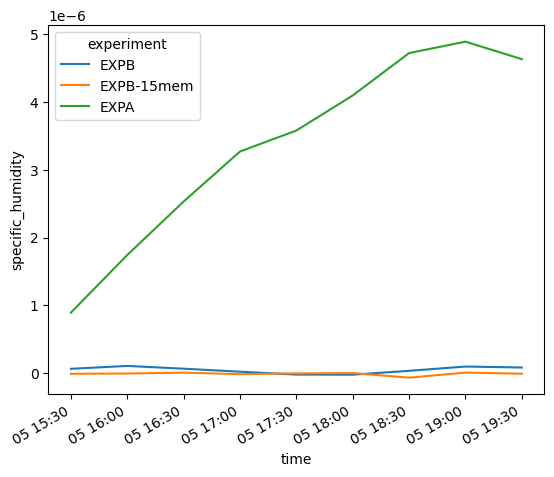

In [7]:
# 1)create an xarray dataset for exp, ens, time, lat, lon, lev

data_dir='/Users/maryamao/JEDI/COMPO/HTLM_results/lin_err'

exp_names = ['EXPB','EXPB-15mem','EXPA']
da_methods = ['HTLM','HTLM','TLM']


# create all datetimes (30min intervals)
n = 9 
start_date = datetime(2021, 8, 5, 15, 30, 0)
time_values = [start_date + timedelta(minutes=30*i) for i in range(n)]
formatted_dates = [dt.strftime('%Y-%m-%dT%H:%M:%SZ') for dt in time_values]
ds_all = xr.Dataset()

for exp_name, da_method in zip(exp_names, da_methods):
    ds = xr.Dataset()
    for wdate in formatted_dates:
        if da_method == 'HTLM':
            fname = 'linearization-error-HTLM-pseudo.inc.'+wdate+'.latlon.modelLevels.nc'
        else:
            fname = 'linearization-error-TLM-genpseudo.inc.'+wdate+'.latlon.modelLevels.nc'

        filenames = []
        for mem in range(1,15):
            mem_dir = f"mem000_mem{mem:03d}"
            filename = os.path.join(data_dir,exp_name,mem_dir,fname)
            filenames.append(filename)
        ds_date = xr.open_mfdataset(filenames, combine='nested',concat_dim='ens')
        ds = xr.concat([ds,ds_date],"time")
    ds = ds.assign_coords(time=('time', time_values))
    ds_all =  xr.concat([ds_all,ds],"experiment")

ds_all = ds_all.assign_coords(experiment=('experiment',exp_names))
ds_all

# example plot
no2 = ds_all['specific_humidity'].isel(levels=-1).mean(dim=['ens','latitude','longitude'])
no2.plot.line(x='time', hue='experiment')
    

In [ ]:
# TS plots
var_names = ['eastward_wind', 'northward_wind', 'air_temperature', 'cloud_liquid_ice', 'cloud_liquid_water',
             'specific_humidity', 'volume_mixing_ratio_of_no2', 'volume_mixing_ratio_of_co', 'volume_mixing_ratio_of_o3']

for var_name in var_names:
    surf_val = ds_all[var_name].isel(levels=-1)
    sq = surf_val ** 2
    mean = sq.mean(dim=['ens','latitude','longitude'])
    var = np.sqrt(mean)
    #var = ds_all[var_name].isel(levels=-1).mean(dim=['ens','latitude','longitude'])
    var.plot.line(x='time', hue='experiment')
    plt.title('RMS linearization error')
    plt.savefig(data_dir+'/TS/TS_EXPA_B_15mem_linerr_'+var_name,bbox_inches='tight',)
    plt.show()

In [18]:
ds_all

<xarray.Dataset>
Dimensions:                     (experiment: 3, time: 9, ens: 14,
                                 latitude: 181, longitude: 360, levels: 72)
Coordinates:
  * time                        (time) datetime64[ns] 2021-08-05T15:30:00 ......
  * latitude                    (latitude) float64 90.0 89.0 ... -89.0 -90.0
  * longitude                   (longitude) float64 0.0 1.0 2.0 ... 358.0 359.0
  * experiment                  (experiment) <U10 'EXPB' 'EXPB-15mem' 'EXPA'
Dimensions without coordinates: ens, levels
Data variables:
    air_temperature             (experiment, time, ens, latitude, longitude, levels) float64 dask.array<chunksize=(1, 1, 1, 181, 360, 72), meta=np.ndarray>
    volume_mixing_ratio_of_co   (experiment, time, ens, latitude, longitude, levels) float64 dask.array<chunksize=(1, 1, 1, 181, 360, 72), meta=np.ndarray>
    model_levels                (experiment, time, ens, levels) int32 dask.array<chunksize=(1, 1, 1, 72), meta=np.ndarray>
    cloud_liquid_ice            (experiment, time, ens, latitude, longitude, levels) float64 dask.array<chunksize=(1, 1, 1, 181, 360, 72), meta=np.ndarray>
    specific_humidity           (experiment, time, ens, latitude, longitude, levels) float64 dask.array<chunksize=(1, 1, 1, 181, 360, 72), meta=np.ndarray>
    cloud_liquid_water          (experiment, time, ens, latitude, longitude, levels) float64 dask.array<chunksize=(1, 1, 1, 181, 360, 72), meta=np.ndarray>
    eastward_wind               (experiment, time, ens, latitude, longitude, levels) float64 dask.array<chunksize=(1, 1, 1, 181, 360, 72), meta=np.ndarray>
    volume_mixing_ratio_of_no2  (experiment, time, ens, latitude, longitude, levels) float64 dask.array<chunksize=(1, 1, 1, 181, 360, 72), meta=np.ndarray>
    volume_mixing_ratio_of_o3   (experiment, time, ens, latitude, longitude, levels) float64 dask.array<chunksize=(1, 1, 1, 181, 360, 72), meta=np.ndarray>
    northward_wind              (experiment, time, ens, latitude, longitude, levels) float64 dask.array<chunksize=(1, 1, 1, 181, 360, 72), meta=np.ndarray>

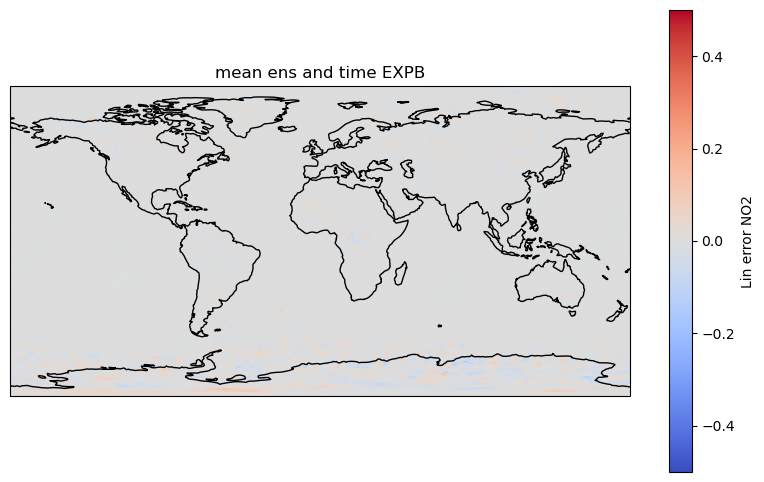

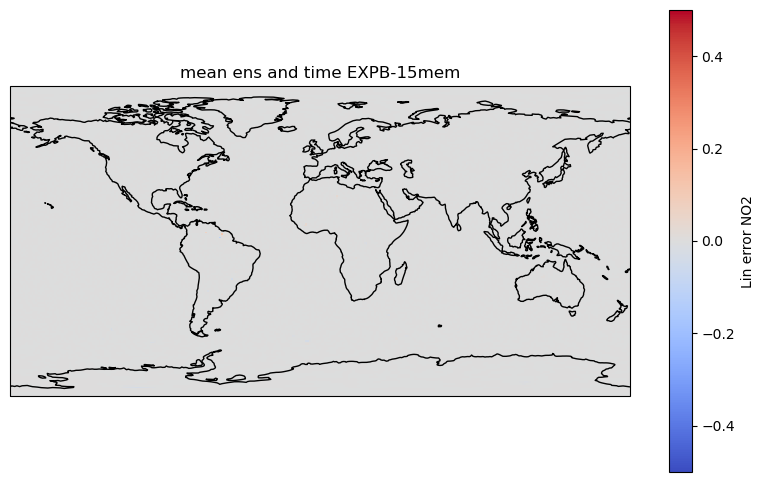

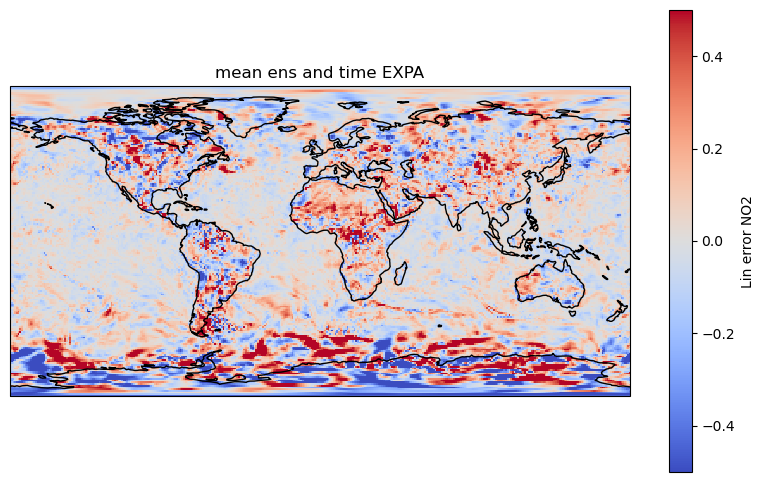

In [36]:

lats = ds['latitude'].values
lons = ds['longitude'].values
var_all = ds_all['air_temperature'].isel(levels=-1).mean(dim=['ens','time'])
for exp in exp_names:
    var = var_all.sel(experiment=exp)
    c_var, clon = add_cyclic_simple(var.values, lons)
    clat = lats

    fig = plt.figure(figsize=(10, 6))

    vmin = -0.5
    vmax = 0.5

    ax1 = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
    ax1.coastlines()
    c1 = ax1.pcolormesh(clon, clat, c_var, cmap='coolwarm' , vmin=vmin, vmax=vmax)
    plt.title('mean ens and time ' + exp)
    plt.colorbar(c1, label="Lin error NO2")
    plt.show()

    

    